In [2]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import os, glob

hdir = '../../All-atom MD/'

# **Analysis of BMC-H subunit flexibility using root mean square fluctuation (RMSF)**

The RMSF per residue $i$ is:

\begin{align} RMSF_i &= \sqrt{ \frac{1}{T} \sum_{t=1}^{T} \left\| \, \mathbf{r}_{i}^{(t)} - \langle \mathbf{r}_{i} \rangle \right\|^2} \end{align}

where $\mathbf{r}_{i}^{(t)}$ is the position of residue $i$ at time $t$ and $\langle \mathbf{r}_i \rangle$ is its time-averaged position within some reference structure. The subunit must first be aligned per frame to this reference, in order to remove global translations or rotations. We will use the frame-averaged structure as the reference, and `mdtraj.Trajectory.superpose` performs the alignment.

In [4]:
# Load trajectory from a directory
def load_trajectory(data_dir):
    print(f'Loading trajectory from {data_dir}')
    topology_file = glob.glob(os.path.join(data_dir, "*.pdb"))[0]
    trajectory_file = glob.glob(os.path.join(data_dir, "*.xtc"))[0]
    traj = md.load(trajectory_file, top=topology_file)
    return traj

# Compute RMSF profile for the two hexamers in each trajectory
def getRMSF(data_dir, residues_per_monomer=99, monomers_per_hexamer=6, atom_selection="name CA"):
    traj = load_trajectory(data_dir)
    residues_per_hexamer = residues_per_monomer * monomers_per_hexamer
    n_hexamers = int(traj.xyz.shape[1] / residues_per_hexamer)

    rmsf_list = []
    for h in range(n_hexamers):
        # Get sub-trajectory of just one hexamer
        i0 = h * residues_per_hexamer
        i1 = (h + 1) * residues_per_hexamer
        subtraj = traj.atom_slice(range(i0, i1))

        # Compute the average structure over the trajectory
        mean_xyz = subtraj.xyz.mean(axis=0)[np.newaxis, :, :]

        # Create a temporary trajectory for alignment
        mean_frame = md.Trajectory(mean_xyz, subtraj.topology)

        # Align all frames to the mean structure
        subtraj.superpose(mean_frame)

        # Compute RMSF for CA atoms (relative to mean)
        rmsf = md.rmsf(subtraj, mean_frame)
        rmsf_list.append(rmsf)

    return rmsf_list

def mean_rmsf(rmsf_dict):
    all_rmsfs = [r for rmsf_list in rmsf_dict.values() for r in rmsf_list]
    stacked = np.vstack(all_rmsfs)
    print(f'# hexamers: {stacked.shape[0]}')
    mean_rmsf = stacked.mean(axis=0)

    return mean_rmsf

def compare_conditions(rmsf_1, rmsf_2, label_1='Condition 1', label_2='Condition 2'):
    fig = plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.plot(rmsf_1, label=label_1, lw=1, color='blue')
    plt.plot(rmsf_2, label=label_2, lw=1, color='red')
    plt.xlabel("Residue")
    plt.ylabel("RMSF (Å)")
    plt.title("RMSF averaged across all BMC-H subunits")
    plt.grid(which='both', linestyle=':', linewidth=0.5)
    plt.ylim(0,2)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(rmsf_1, rmsf_2, s=10, alpha=0.25, edgecolors='none')
    plt.plot([0, 2], [0, 2], 'k:')
    plt.title("RMSF comparison b/w conditions")
    plt.xlabel(label_1)
    plt.ylabel(label_2)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both', linestyle=':', linewidth=0.5)

    plt.tight_layout()
    plt.show()

# **Trajectories in the `metadynamics/` folder**

| Salt | Set | Topology file | Trajectory file |
|-|-|-|-|
| `H_H_0/` | `set1/` | `CA.pdb` | `CAwrapped.xtc` |
|  | `set2/` | `CA.pdb` | `CAwrapped.xtc` |
|  | `set3/` | `CA.pdb` | `CAwrapped.xtc` |
| `H_H_500/` | `set1/` | `CA.pdb` | `CAwrapped.xtc` |
|  | `set2/` | `CA.pdb` | `CAwrapped.xtc` |
|  | `set3/` | `CA.pdb` | `CAwrapped.xtc` |

In [6]:
meta_0 = hdir + 'metadynamics/H_H_0/'
meta_set_dirs_0 = np.sort(glob.glob(os.path.join(meta_0, 'set*')))

meta_500 = hdir + 'metadynamics/H_H_500/'
meta_set_dirs_500 = np.sort(glob.glob(os.path.join(meta_500, 'set*')))

rmsf_meta_lists_0 = {}
for d in meta_set_dirs_0:
    rmsf_list = getRMSF(d)
    rmsf_meta_lists_0[d] = rmsf_list
rmsf_meta_0 = mean_rmsf(rmsf_meta_lists_0)

rmsf_meta_lists_500 = {}
for d in meta_set_dirs_500:
    rmsf_list = getRMSF(d)
    rmsf_meta_lists_500[d] = rmsf_list
rmsf_meta_500 = mean_rmsf(rmsf_meta_lists_500)

Loading trajectory from ../../All-atom MD/metadynamics/H_H_0/set1
Loading trajectory from ../../All-atom MD/metadynamics/H_H_0/set2
Loading trajectory from ../../All-atom MD/metadynamics/H_H_0/set3
# hexamers: 6
Loading trajectory from ../../All-atom MD/metadynamics/H_H_500/set1
Loading trajectory from ../../All-atom MD/metadynamics/H_H_500/set2
Loading trajectory from ../../All-atom MD/metadynamics/H_H_500/set3
# hexamers: 6


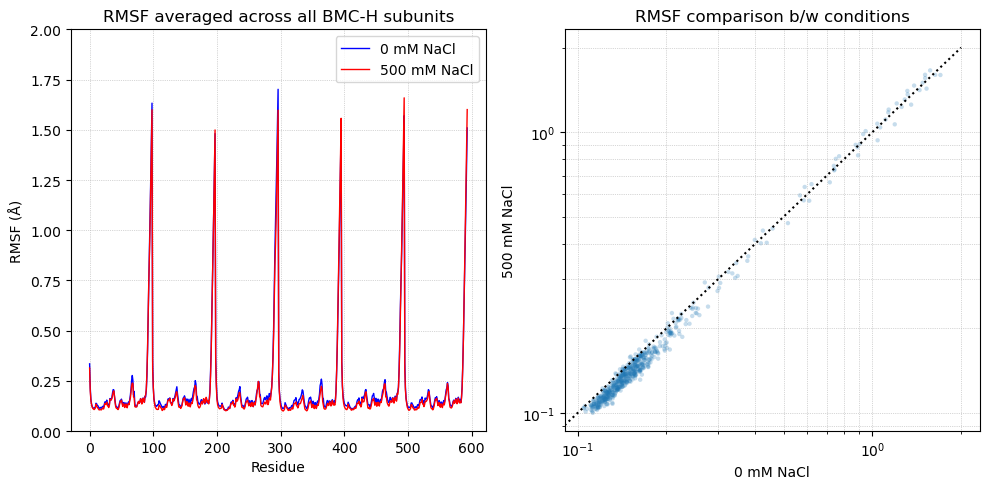

In [7]:
# 0 mM vs. 500 mM, no urea
compare_conditions(rmsf_meta_0, rmsf_meta_500, label_1='0 mM NaCl', label_2='500 mM NaCl')

# **Trajectories in the `umbrella/` folder**

Horizontal:
| | | Salt / Urea | Topology file | Trajectory file |
|-|-|-|-|-|
| `H_H/horizontal/` | |`0mM/` | `CA.pdb` | `CA.xtc` |
| | | `100mM/` | `CA.pdb` | `CA.xtc` |
| | | `500mM/` | `CA.pdb` | `CA.xtc` |
| |
| | | `0mM_urea/` | `CA.pdb` | `CA.xtc` |
| | | `100mM_urea/` | `CA.pdb` | `CA.xtc` |
| | | `500mM_urea/` | `CA.pdb` | `CA.xtc` |



Vertical:

| | Stack orientation | Salt / Urea | Topology file | Trajectory file |
|-|-|-|-|-|
| `H_H/vertical/` | `zii/` | `0mM/` | `CA.pdb` | `CA.xtc` |
| | | `100mM/` | `CA.pdb` | `CA.xtc` |
| | | `500mM/` | `CA.pdb` | `CA.xtc` |
| |
| | | `0mM_urea/` | `CA.pdb` | `CA.xtc` |
| | | `100mM_urea/` | `CA.pdb` | `CA.xtc` |
| | | `500mM_urea/` | `CA.pdb` | `CA.xtc` |
| |
| | `zio/` | `0mM/` | `CA.pdb` | `CA.xtc` |
| | | `100mM/` | `CA.pdb` | `CA.xtc` |
| | | `500mM/` | `CA.pdb` | `CA.xtc` |
| |
| | | `0mM_urea/` | `CA.pdb` | `CA.xtc` |
| | | `100mM_urea/` | `CA.pdb` | `CA.xtc` |
| | | `500mM_urea/` | `CA.pdb` | `CA.xtc` |
| |
| | `zoo/` | `0mM/` | `CA.pdb` | `CA.xtc` |
| | | `100mM/` | `CA.pdb` | `CA.xtc` |
| | | `500mM/` | `CA.pdb` | `CA.xtc` |
| |
| | | `0mM_urea/` | `CA.pdb` | `CA.xtc` |
| | | `100mM_urea/` | `CA.pdb` | `CA.xtc` |
| | | `500mM_urea/` | `CA.pdb` | `CA.xtc` |
| |


In [9]:
# Load umbrella sampling data, no urea
umbrella_0N = hdir + 'umbrella/H_H/horizontal/0mM/'
umbrella_500N = hdir + 'umbrella/H_H/horizontal/500mM/'

rmsf_0 = getRMSF(umbrella_0N)
rmsf_500 = getRMSF(umbrella_500N)

rmsf_umb_lists_0 = {}; rmsf_umb_lists_0[umbrella_0N] = rmsf_0
rmsf_umb_lists_500 = {}; rmsf_umb_lists_500[umbrella_500N] = rmsf_500

rmsf_umb_0 = mean_rmsf(rmsf_umb_lists_0)
rmsf_umb_500 = mean_rmsf(rmsf_umb_lists_500)

Loading trajectory from ../../All-atom MD/umbrella/H_H/horizontal/0mM/
Loading trajectory from ../../All-atom MD/umbrella/H_H/horizontal/500mM/
# hexamers: 2
# hexamers: 2


In [10]:
# Load umbrella sampling data, with urea
umbrella_0N_100U = hdir + 'umbrella/H_H/horizontal/0mM_urea/'
umbrella_500N_100U = hdir + 'umbrella/H_H/horizontal/500mM_urea/'

rmsf_0u = getRMSF(umbrella_0N_100U)
rmsf_500u = getRMSF(umbrella_500N_100U)

rmsf_umb_lists_0u = {}; rmsf_umb_lists_0u[umbrella_0N_100U] = rmsf_0u
rmsf_umb_lists_500u = {}; rmsf_umb_lists_500u[umbrella_500N_100U] = rmsf_500u

rmsf_umb_0u = mean_rmsf(rmsf_umb_lists_0u)
rmsf_umb_500u = mean_rmsf(rmsf_umb_lists_500u)

Loading trajectory from ../../All-atom MD/umbrella/H_H/horizontal/0mM_urea/
Loading trajectory from ../../All-atom MD/umbrella/H_H/horizontal/500mM_urea/
# hexamers: 2
# hexamers: 2


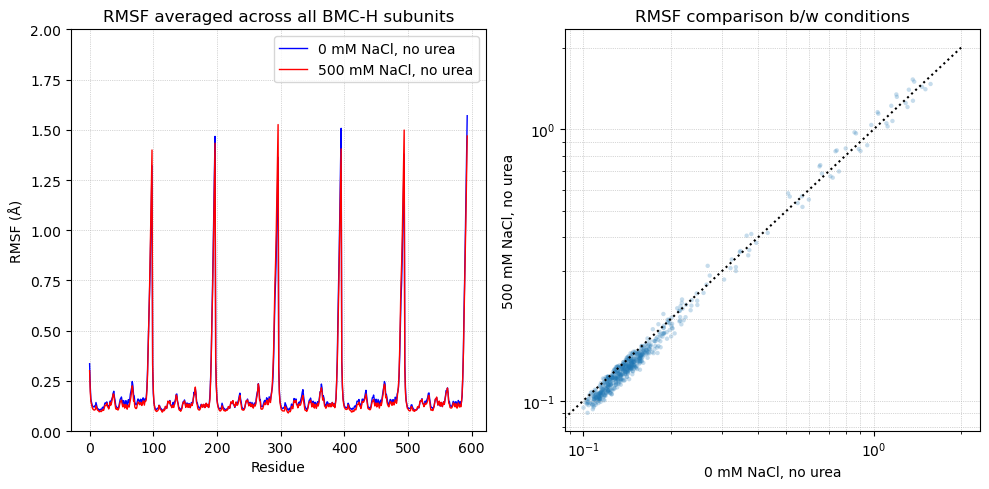

In [11]:
# 0 mM vs. 500 mM, no urea
compare_conditions(rmsf_umb_0, rmsf_umb_500, label_1='0 mM NaCl, no urea', label_2='500 mM NaCl, no urea')

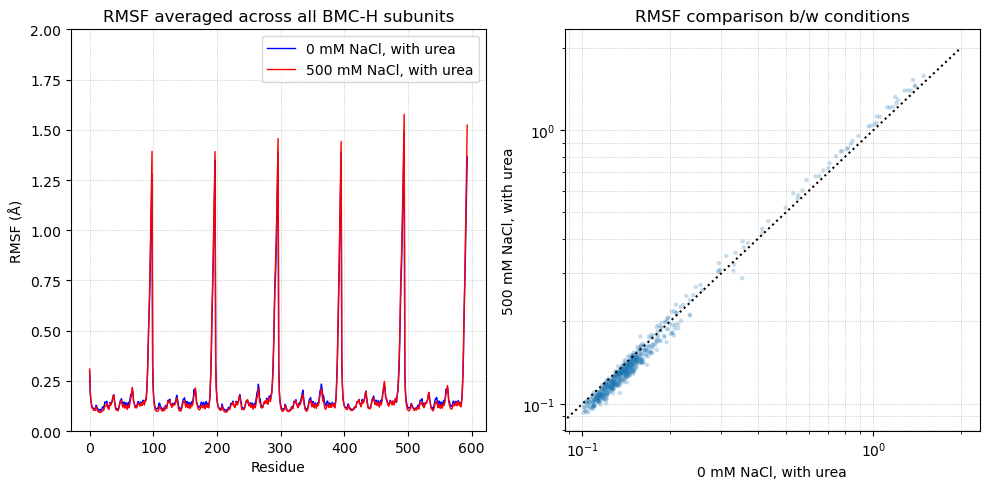

In [12]:
# 0 mM vs. 500 mM, with urea
compare_conditions(rmsf_umb_0u, rmsf_umb_500u, label_1='0 mM NaCl, with urea', label_2='500 mM NaCl, with urea')

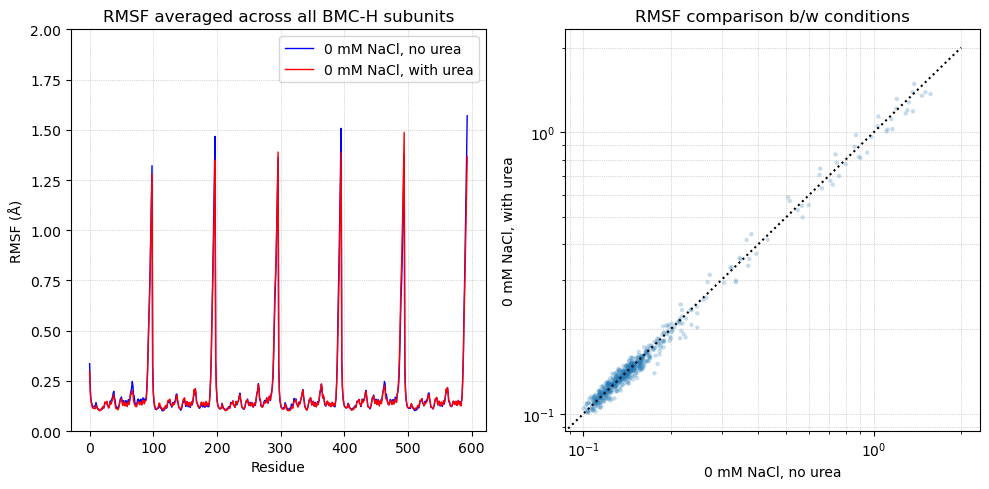

In [13]:
# 0 mM NaCl no urea vs. 0 mM NaCl with urea
compare_conditions(rmsf_umb_0, rmsf_umb_0u, label_1='0 mM NaCl, no urea', label_2='0 mM NaCl, with urea')

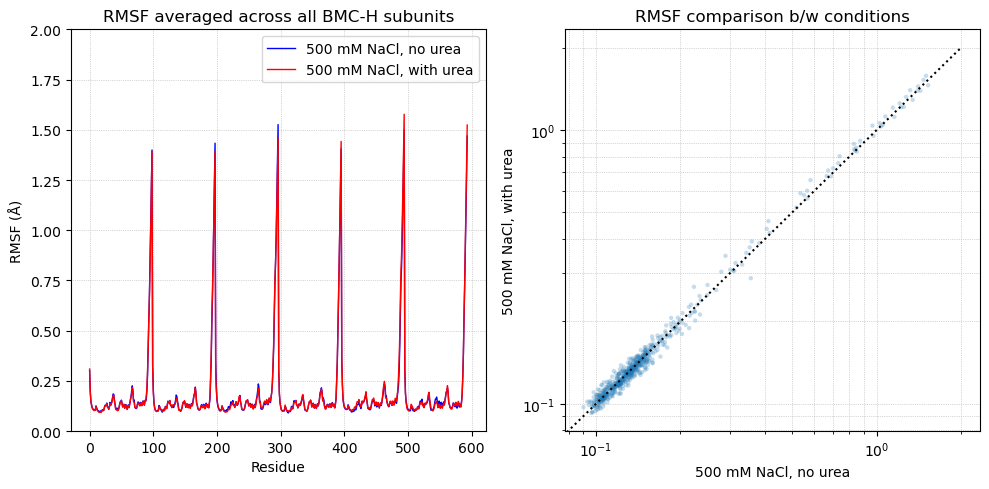

In [14]:
# 500 mM NaCl no urea vs. 500 mM NaCl with urea
compare_conditions(rmsf_umb_500, rmsf_umb_500u, label_1='500 mM NaCl, no urea', label_2='500 mM NaCl, with urea')